In [1]:
from itertools import product

def hamming_distance(s1,s2):
    assert len(s1)==len(s2), 'strings must be same length'
    return sum([1 for i in range(len(s1)) if s1[i]!=s2[i]])

def match_proportion(s1,s2):
    return 1 - (hamming_distance(s1,s2)/len(s1))

def embedded_patterns(S, short, match):
    return [i for i in range(len(S)-len(short)+1)
             if match_proportion(short, S[i:i+len(short)])>=match]

def embedded_with_gap(S,s1,s2, match):
    pos1 = embedded_patterns(S, s1, match)
    pos2 = embedded_patterns(S, s2, match)

    return min(pos1) + len(s1) < max(pos2)

def string_contains_pattern_list(S,P,match):
    #False if P is empty
    #True if a single pattern is present
    
    if len(P) == 0:
        return False
    elif len(P) == 1:
        return len(embedded_patterns(S,P[0],match))>0
    else:
        return all([embedded_with_gap(S,P[i],P[i+1], match) for i in range(len(P)-1)])

def scoring_function(lmin, P):
    return len([x for x in P if len(x)>lmin])

def neighbors(p,match): #for given distance d returns set of approximate matches to input string p
    k = len(p)
    
    d = int(k*(1-match))
    if d==0:
        return {p}

    cur_matches = [[p]]

    possible = [x for x in product([0,1], repeat=k) if sum(x)<=d]

    for cur_mix in possible:

        cur_matches.append([''.join(x) for x in product(
                        *[set(p[i]) if cur_mix[i]==0 
                          else set('ATCG')-set(p[i])
                            for i in range(k)])
                      ])

    cur_matches = set([x for m_list in cur_matches for x in m_list])
    
    return cur_matches


In [3]:
import random
import time
from collections import Counter
import pandas as pd


def test_generating_possible_patterns(I,lmin):
    
    prev = time.time()

    possible_patterns = {}

    for i in range(len(I)):
        S = I[i]
        for k in range(lmin+1,(len(S)-1)//2 + 1):
            for j in range(len(S)-k+1):
                cur = S[j:j+k]
                cur_patterns = neighbors(cur,match)

                for pat in cur_patterns:
                    try:
                        possible_patterns[pat][i].append((j,k))
                    except:
                        try:
                            possible_patterns[pat][i] = [(j,k)]
                        except:
                            possible_patterns[pat] = {i:[(j,k)]}
                            
    max_len = len(possible_patterns)
    for k in [key for key in possible_patterns if len(possible_patterns[key])!=len(I)]:
        del possible_patterns[k]
                            
    cur = time.time()
    
    return cur-prev, len(possible_patterns), max_len,possible_patterns

def random_mutate(base_string, param = 0.2):
    #mu = param*length of base_string
    #std_dev = mu/3
    #change to poisson if allowed...the mu/3 thing is to make it approximately normal around ~20% of sequence length
    
    num_muts = abs(round(random.gauss(param*len(base_string), param*len(base_string)/3)))
    mut_pos = [random.randint(0,len(base_string)-1) for _ in range(num_muts)]

    new_string = list(base_string)

    for x in mut_pos:
        new_string[x] = random.choice(list(set(alphabet)-set(new_string[x])))

    return ''.join(new_string)

def get_base_string(alphabet, string_lenth):
    return ''.join(random.choices(alphabet, k=string_length))
    
#reproducibility
random.seed(666, 2)


dna_alphabet = 'ACGT'
rna_alphabet = 'ACGU'
prot_alphabet = 'ACDEFGHIKLMNPQRSTVWY'
alphabet = dna_alphabet


match = 0.7
lmin = 2
string_length = 20
num_strings = 4
alpha_length = len(alphabet)


res = [('Rep','Total time', 'Pattern generation time', 'Possible Patterns', 'Possible Patterns Max Size', 'Alphabet size', 'String length', 'Match', 'lmin')]


for string_length in [10,20,30]:
    for _ in range(5):
        prev = time.time()
        base_string = get_base_string(alphabet, string_length)
        mut_strings = [random_mutate(base_string) for _ in range(num_strings)]
        a,b,c,d = test_generating_possible_patterns(mut_strings, lmin)

        fin = time.time()
        res.append((_+1, round(fin-prev,3), round(a,3), b,c, len(alphabet), string_length, match,lmin))
        
res_df = pd.DataFrame(res[1:], columns = res[0])
res_df.to_csv('Changing Inclusion Size Trial I {w} S {x} lmin {y}.csv'.format(w = num_strings, x=string_length, y=lmin))

C:\Users\dmeye\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


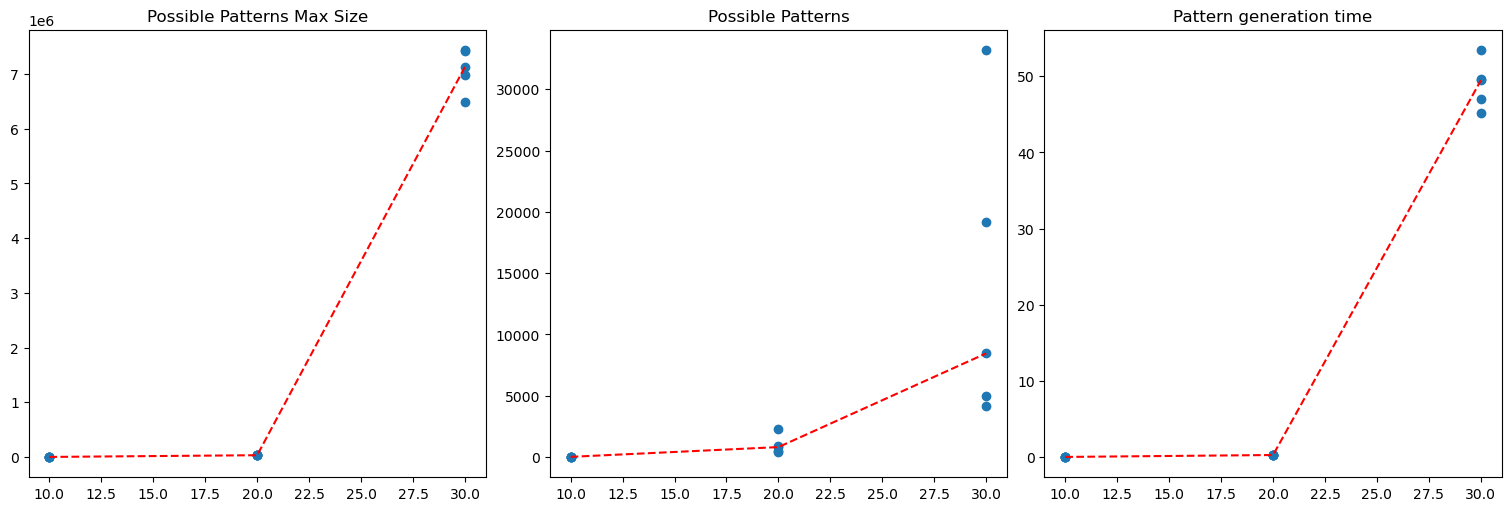

C:\Users\dmeye\anaconda3\lib\site-packages\numpy\lib\function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


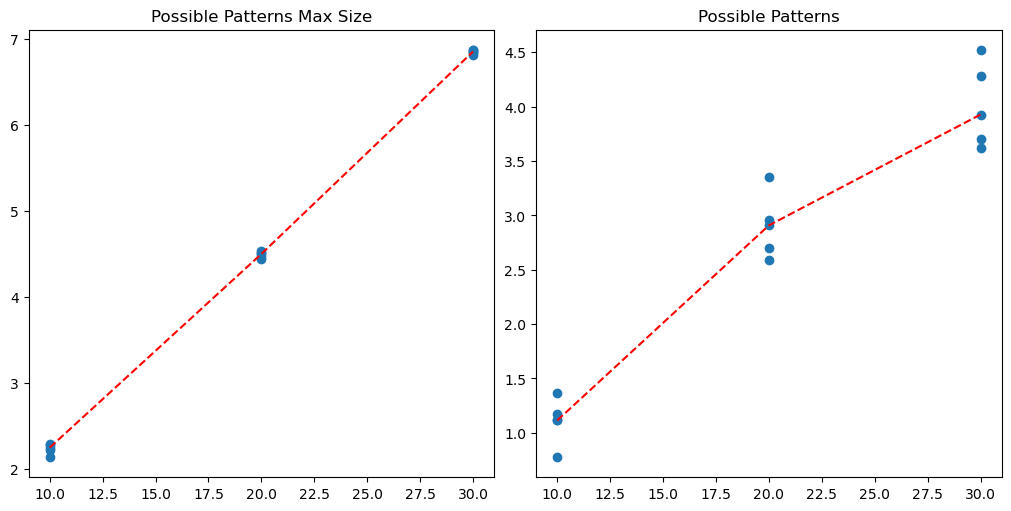

In [37]:
#graphs correspond to patterns of size 3+ in Inclusion strings of length 10,20,30
#left graph is the largest number of unique patterns stored in a dictionary
#middle graph is the number of unique patterns embedded in all inclusion strings
#    next step of checking pattern combinations would scale based on this size
#right graph is the run time for generating possible combinations

import matplotlib.pyplot as plt
import numpy as np


graph_df = pd.read_csv('Changing Inclusion Size Trial.csv', index_col = 0)
log_df = np.log10(graph_df)



xcol = graph_df['String length']


for df,ycol_list in zip([graph_df, log_df],
                        [['Possible Patterns Max Size', 'Possible Patterns', 'Pattern generation time'],
                         ['Possible Patterns Max Size','Possible Patterns']]):

    median_table = pd.DataFrame({temp:df[xcol==temp].quantile(0.5)[ycol_list] for temp in set(xcol)}).T



    fig,axes = plt.subplots(1, len(ycol_list),constrained_layout = True)
    fig.set_size_inches((5*len(ycol_list),5))


    for ycol,ax in zip(ycol_list, axes):
        ax.scatter(xcol,df[ycol])
        ax.plot(median_table.index, median_table[ycol], color = 'red', linestyle = 'dashed')

        ax.set_title(ycol)

    plt.show()




In [36]:
graph_df

,Rep,Total time,Pattern generation time,Possible Patterns,Possible Patterns Max Size,Alphabet size,String length,Match,lmin
0,1,0.000,0.000,13,187,4,10,0.7,2
1,2,0.000,0.000,13,192,4,10,0.7,2
2,3,0.008,0.008,23,163,4,10,0.7,2
3,4,0.000,0.000,15,137,4,10,0.7,2
4,5,0.000,0.000,6,176,4,10,0.7,2
5,1,0.222,0.222,905,29196,4,20,0.7,2
6,2,0.252,0.252,809,32725,4,20,0.7,2
7,3,0.220,0.220,2273,27474,4,20,0.7,2
8,4,0.318,0.318,390,33791,4,20,0.7,2
9,5,0.309,0.306,505,31545,4,20,0.7,2


In [70]:
class node: #each node is a unique occurence of a pattern in the string; maybe add in match proportion??
    def __init__(self,cur_id, prev_ids, txt,pos):
        self.id = cur_id
        self.par = prev_ids
        self.child = []
        self.txt = txt
        self.pos = pos
        self.k = len(txt)
        
    def __str__(self):
        return str(self.id) + ' '+ str(self.txt) + ' ' + str(self.pos)
    
    def get_id(self):
        return self.id
    
    
class tree:
    def __init__(self):
        self.head = node(0, None, '', None)
        self.tail = node(-1, [], '', None)
        self.next_id = 1
        self.edges = {}
        self.nodes = {0:self.head, -1:self.tail}
        
                
    def add_node(self, txt,pos,from_head = False, to_tail = False):
        self.nodes[self.next_id] = node(self.next_id, [], txt,pos)
        
        if from_head:
            self.add_edge(self.head, self.nodes[self.next_id])
            
        if to_tail:
            self.add_edge(self.nodes[self.next_id],self.tail)
        
        self.next_id+=1
        
    def add_edge(self, n1,n2):
        id1 = n1.id
        id2 = n2.id
        
        n2.par.append(id1)
        n1.child.append(id2)
        try:
            self.edges[id1].append(id2)
        except:
            self.edges[id1] = [id2]
            
            
    def remove_edge(self, n1,n2):
        id1 = n1.id
        id2 = n2.id
        
        try:
            del n2.par[n2.par.index(id1)]
        except:
            pass
        
        try:
            del n1.child[n1.child.index(id2)]
        except:
            pass
        
        try:
            del self.edges[id1][self.edges[id1].index(id2)]
        except:
            pass
        
        
    
    def remove_node(self, n1):
        pass #complex shit about iterating through parent and child nodes
        
        
    def print_tree(self):
        print(self.nodes)
        print(self.edges)
        
    def get_nodes(self):
        return self.nodes
        
#TODO: implement remove_node feature
#TODO: implement longest_path
#              a set of longest paths from self.head to self.tail
#              #consider implementing edge weights or something to prioritize these paths

46 TGXTT 6


In [71]:
for id_num in t.edges[0]:
    print(t.nodes[id_num])

1 ATG 0
2 TGX 1
3 GXX 2
4 XXA 3
5 XAT 4
6 ATG 5
7 TGX 6
8 GXT 7
9 XTT 8
10 TTA 9
11 TAA 10
12 AAX 11
13 AXA 12
14 XAT 13
15 ATG 14
16 TGX 15
17 GXT 16
18 XTT 17
19 TTA 18
20 TAA 19
21 ATGX 0
22 TGXX 1
23 GXXA 2
24 XXAT 3
25 XATG 4
26 ATGX 5
27 TGXT 6
28 GXTT 7
29 XTTA 8
30 TTAA 9
31 TAAX 10
32 AAXA 11
33 AXAT 12
34 XATG 13
35 ATGX 14
36 TGXT 15
37 GXTT 16
38 XTTA 17
39 TTAA 18
40 ATGXX 0
41 TGXXA 1
42 GXXAT 2
43 XXATG 3
44 XATGX 4
45 ATGXT 5
46 TGXTT 6
47 GXTTA 7
48 XTTAA 8
49 TTAAX 9
50 TAAXA 10
51 AAXAT 11
52 AXATG 12
53 XATGX 13
54 ATGXT 14
55 TGXTT 15
56 GXTTA 16
57 XTTAA 17
58 ATGXXA 0
59 TGXXAT 1
60 GXXATG 2
61 XXATGX 3
62 XATGXT 4
63 ATGXTT 5
64 TGXTTA 6
65 GXTTAA 7
66 XTTAAX 8
67 TTAAXA 9
68 TAAXAT 10
69 AAXATG 11
70 AXATGX 12
71 XATGXT 13
72 ATGXTT 14
73 TGXTTA 15
74 GXTTAA 16
75 ATGXXAT 0
76 TGXXATG 1
77 GXXATGX 2
78 XXATGXT 3
79 XATGXTT 4
80 ATGXTTA 5
81 TGXTTAA 6
82 GXTTAAX 7
83 XTTAAXA 8
84 TTAAXAT 9
85 TAAXATG 10
86 AAXATGX 11
87 AXATGXT 12
88 XATGXTT 13
89 ATGXTTA 14
90 

In [97]:
node_list = sorted([t.nodes[id_num] for id_num in t.edges[0]], key = lambda x: x.pos)
    
    
pos_dic = {n.id:i for i,n in enumerate(node_list)}


for n in node_list:
    print(n.id, n.txt, n.pos, n.k, pos_dic[n.pos+2 + n.k])

1 ATG 0 3 32
21 ATGX 0 4 40
40 ATGXX 0 5 48
58 ATGXXA 0 6 56
75 ATGXXAT 0 7 64
91 ATGXXATG 0 8 72
106 ATGXXATGX 0 9 80
120 ATGXXATGXT 0 10 88
2 TGX 1 3 40
22 TGXX 1 4 48
41 TGXXA 1 5 56
59 TGXXAT 1 6 64
76 TGXXATG 1 7 72
92 TGXXATGX 1 8 80
107 TGXXATGXT 1 9 88
121 TGXXATGXTT 1 10 96
3 GXX 2 3 48
23 GXXA 2 4 56
42 GXXAT 2 5 64
60 GXXATG 2 6 72
77 GXXATGX 2 7 80
93 GXXATGXT 2 8 88
108 GXXATGXTT 2 9 96
122 GXXATGXTTA 2 10 104
4 XXA 3 3 56
24 XXAT 3 4 64
43 XXATG 3 5 72
61 XXATGX 3 6 80
78 XXATGXT 3 7 88
94 XXATGXTT 3 8 96
109 XXATGXTTA 3 9 104
123 XXATGXTTAA 3 10 111
5 XAT 4 3 64
25 XATG 4 4 72
44 XATGX 4 5 80
62 XATGXT 4 6 88
79 XATGXTT 4 7 96
95 XATGXTTA 4 8 104
110 XATGXTTAA 4 9 111
124 XATGXTTAAX 4 10 117
6 ATG 5 3 72
26 ATGX 5 4 80
45 ATGXT 5 5 88
63 ATGXTT 5 6 96
80 ATGXTTA 5 7 104
96 ATGXTTAA 5 8 111
111 ATGXTTAAX 5 9 117
125 ATGXTTAAXA 5 10 122
7 TGX 6 3 80
27 TGXT 6 4 88
46 TGXTT 6 5 96
64 TGXTTA 6 6 104
81 TGXTTAA 6 7 111
97 TGXTTAAX 6 8 117
112 TGXTTAAXA 6 9 122
126 TGXTTAAXAT 

In [107]:
pos_dic = {temp[i][0]+1:i+1 for i in range(len(temp)-1) if temp[i]!=temp[i+1]}
pos_dic[0] = 0


cur_id = 27
cur_node = t.nodes[cur_id]

print(cur_node, cur_node.pos, cur_node.k)

27 TGXT 6 6 4


In [108]:
'ATGXXATGXTTAAXATGXTTAA'
      'TGXT'
           'AAXATGXTTAA'

'ATGXXATGXTTAAXATGXTTAA'

In [111]:
pos_dic[11]

88

In [114]:
temp[pos_dic[11]:]

[(11, 3),
 (11, 4),
 (11, 5),
 (11, 6),
 (11, 7),
 (11, 8),
 (11, 9),
 (11, 10),
 (12, 3),
 (12, 4),
 (12, 5),
 (12, 6),
 (12, 7),
 (12, 8),
 (12, 9),
 (12, 10),
 (13, 3),
 (13, 4),
 (13, 5),
 (13, 6),
 (13, 7),
 (13, 8),
 (13, 9),
 (14, 3),
 (14, 4),
 (14, 5),
 (14, 6),
 (14, 7),
 (14, 8),
 (15, 3),
 (15, 4),
 (15, 5),
 (15, 6),
 (15, 7),
 (16, 3),
 (16, 4),
 (16, 5),
 (16, 6),
 (17, 3),
 (17, 4),
 (17, 5),
 (18, 3),
 (18, 4),
 (19, 3)]

In [87]:
(len(S)-1)//2 - lmin

8